In [161]:
import os
import sys
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import sys
#np.set_printoptions(threshold=sys.maxsize)

'''
Nota:
Sem o uso da máscara

Carla
carla.readthedocs.io/

Ross Kippenbrock - Finding Lane Lines for Self Driving Cars [Palestra]
https://www.youtube.com/watch?v=VyLihutdsPk
https://github.com/rkipp1210/pydata-berlin-2017

Detect Lanes for Self-Driving Cars | OpenCV Python Tutorial | Computer Vision Tutorial [vídeo-aula]
https://www.youtube.com/watch?v=ZKijZw7OPcY

Canny
Hough Transform


Perspective transformation – OpenCV 3.4 with python 3 Tutorial 13 [vídeo-aula]
https://www.youtube.com/watch?v=PtCQH93GucA

Biblioteca OpenCV
%https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a
%https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

%%
Futuramente:
Aproximação polinomial ou linear

Aproximação polinomial
https://www.geeksforgeeks.org/opencv-real-time-road-lane-detection/

'''

'\nNota:\nSem o uso da máscara\n\nCarla\ncarla.readthedocs.io/\n\nRoss Kippenbrock - Finding Lane Lines for Self Driving Cars [Palestra]\nhttps://www.youtube.com/watch?v=VyLihutdsPk\nhttps://github.com/rkipp1210/pydata-berlin-2017\n\nDetect Lanes for Self-Driving Cars | OpenCV Python Tutorial | Computer Vision Tutorial [vídeo-aula]\nhttps://www.youtube.com/watch?v=ZKijZw7OPcY\n\nCanny\nHough Transform\n\n\nPerspective transformation – OpenCV 3.4 with python 3 Tutorial 13 [vídeo-aula]\nhttps://www.youtube.com/watch?v=PtCQH93GucA\n\nBiblioteca OpenCV\n%https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a\n%https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html\n\n%%\nFuturamente:\nAproximação polinomial ou linear\n\nAproximação polinomial\nhttps://www.geeksforgeeks.org/opencv-real-time-road-lane-detection/\n\n'

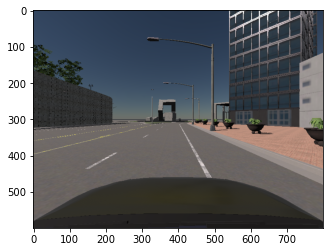

In [162]:
filename='/home/wenderson/testes/00049664.png'
#filename='/home/wenderson/Downloads/CARLA_0.9.7.3/PythonAPI/examples/meus/_out/1.png'
src = cv.imread(cv.samples.findFile(filename))
src=src[:,:,::-1] #inverte as cores (vem ao contrário e a imagem fica azulada)
#print("Shape:", src.shape)

plt.figure()
plt.imshow(src)


In [163]:
y=600
x=800

'''
pts1 e pts2 são regiões de interese
-cuidado ao abrir a ROI, com os pts1e2, pois pequenas alterações causam grandes efeitos
'''
pts1=np.float32([
     [200,350],
     [600,350],
     [100,450],
     [600,450]
])

#esq_sup, dir_sup, esq_inf, dir_inf
pts2=np.float32([
     [0,0],
     [x,0],
     [0,y],
     [x,y]
])

def warper(img):
    # Compute and apply perpective transform
    x,y = img.shape[1], img.shape[0]
    M = cv.getPerspectiveTransform(pts1, pts2)
    return cv.warpPerspective(img, M, (x,y))#, flags=cv2.INTER_NEAREST)  # keep same size as input image

def unwarp(img):
    # Compute and apply inverse perpective transform
    x,y = img.shape[1], img.shape[0]
    Minv = cv.getPerspectiveTransform(pts2, pts1)
    return cv.warpPerspective(img, Minv, (x,y))#, flags=cv2.INTER_NEAREST)

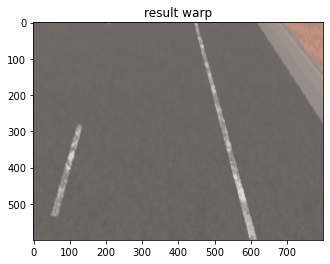

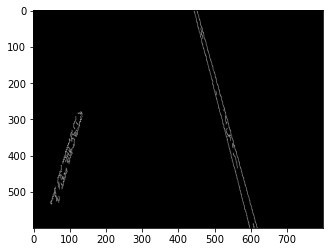

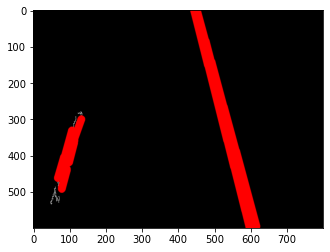

In [164]:
result = warper(src)
plt.figure()
plt.title("result warp")
plt.imshow(result)

canny = cv.Canny(result, 50, 200, apertureSize=3)
canny_hough = cv.cvtColor(canny, cv.COLOR_GRAY2BGR)
plt.figure()
plt.imshow(canny_hough, cmap='gray')

lines = cv.HoughLinesP(canny, 1, np.pi / 180, 50, None, 50, 10)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        cv.line(canny_hough, (x1, y1), (x2, y2), (255,0,0), 20, cv.LINE_AA)

plt.figure()
plt.imshow(canny_hough, cmap='gray')

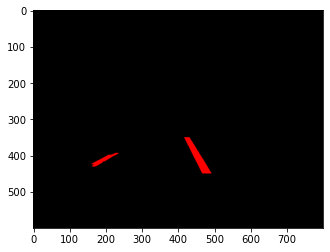

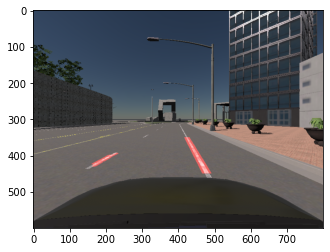

In [165]:
#Imagem apenas com as linhas
line_image = np.zeros((canny_hough.shape[0],canny_hough.shape[1],3), dtype=np.uint8)
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    cv.line(line_image, (x1, y1), (x2, y2), (255,0,0), 20, cv.LINE_AA)
    #imagem que recebe as linhas, a posicao x1,y1;x2,y2 ; a cor da reta; a espessura, tipo da linha

alfa=1 # menor, mais escura
beta=0.5 # maior, mais as linhas aparecem
gama=0 

#plt.figure()
#plt.imshow(line_image)

'''
Desachata as linhas 
'''
lines_unwarped=unwarp(line_image)
plt.figure()
plt.imshow(lines_unwarped) 

'''
Une as linhas com a imagem original
'''
image_with_lines=cv.addWeighted(src, alfa, lines_unwarped, beta, gama)
plt.figure()
plt.imshow(image_with_lines) 

#unwarp
#pos_unwarp=unwarp(image_with_lines)
#plt.figure()
#plt.imshow(pos_unwarp, cmap='gray')


In [210]:
left_fit = []
right_fit = []
for line in lines:
    x1, y1, x2, y2 = line.reshape(4) 
    parameters = np.polyfit((x1, x2), (y1, y2), 1)
    #inclinação (coeficiente angular)
    angulo = parameters[0]
    #intercepta o y (coef. linear) = b
    linear = parameters[1]
    if angulo < 0: 
        left_fit.append((angulo, linear)) 
    else: 
        right_fit.append((angulo, linear)) 
              
    #como são varias retas, faz a média entre elas
    left_fit_average = np.average(left_fit, axis = 0) 
    right_fit_average = np.average(right_fit, axis = 0)

def create_coordinates(image_size, line_fit_average):
    '''
    calcula dois pontos (x1,y1 e x2,y2) na reta da esquerda e direita, para serem usadas
    no desenho da reta (cv.line)
    -apresento o ponto inicial da reta e o ponto final (o cv.line() irá criar a reta entre os pontos dados)
    '''
    angulo, linear = line_fit_average 
    y1 = image_size[0] 
    y2 = int(y1 * (3 / 5)) 
    x1 = int((y1 - linear) / angulo) 
    x2 = int((y2 - linear) / angulo) 
    return np.array([x1, y1, x2, y2]) 


left_line = create_coordinates((600,800), left_fit_average)
print(left_line)
right_line = create_coordinates((600,800), right_fit_average) 
print(right_line)

center_lane=np.sum((left_line, right_line), axis=0)/2
center_lane=center_lane.astype(int)
print(center_lane)

[ 39 600 108 360]
[605 600 542 360]
[322 600 325 360]


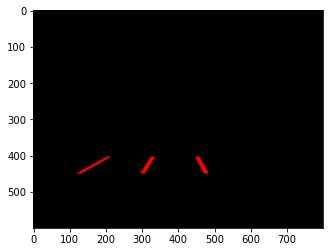

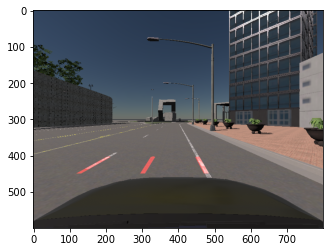

In [211]:
#TEMPORARIO
#Imagem apenas com as linhas
line_image = np.zeros((canny_hough.shape[0],canny_hough.shape[1],3), dtype=np.uint8)
for line in (left_line, right_line, center_lane):
    x1, y1, x2, y2 = line.reshape(4)
    cv.line(line_image, (x1, y1), (x2, y2), (255,0,0), 20, cv.LINE_AA)
    #imagem que recebe as linhas, a posicao x1,y1;x2,y2 ; a cor da reta; a espessura, tipo da linha

alfa=1 # menor, mais escura
beta=0.5 # maior, mais as linhas aparecem
gama=0 

#plt.figure()
#plt.imshow(line_image)

'''
Desachata as linhas 
'''
lines_unwarped=unwarp(line_image)
plt.figure()
plt.imshow(lines_unwarped) 

'''
Une as linhas com a imagem original
'''
image_with_lines=cv.addWeighted(src, alfa, lines_unwarped, beta, gama)
plt.figure()
plt.imshow(image_with_lines) 

#unwarp
#pos_unwarp=unwarp(image_with_lines)
#plt.figure()
#plt.imshow(pos_unwarp, cmap='gray')
